# Radiotherapy AI's Open Source Autocontouring Library

https://github.com/RadiotherapyAI/rai

In [ ]:
# RAi, machine learning solutions in radiotherapy
# Copyright (C) 2021-2022 Radiotherapy AI Holdings Pty Ltd

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU Affero General Public License as
# published by the Free Software Foundation, either version 3 of the
# License, or (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU Affero General Public License for more details.

# You should have received a copy of the GNU Affero General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.

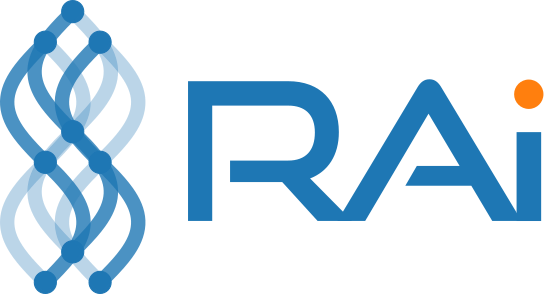

# Disclosure of Conflict of Interest

Simon Biggs, the presenter of this workshop owns Radiotherapy AI which is building a Medical Device based on the open source library being presented within this workshop.

## Installing and importing various packages

In [ ]:
import sys
sys.version

In [ ]:
!pip install rai==0.2.0-dev9

In [ ]:
import pathlib
from io import BytesIO
import zipfile
import tqdm
import numpy as np
import skimage.measure
import matplotlib.pyplot as plt

In [ ]:
import pydicom
pydicom.__version__

In [ ]:
import rai
rai.__version__

In [ ]:
import raicontours

from raicontours import TG263, dicom_utilisation

raicontours.__version__

## The contour model configuration

In [ ]:
cfg = raicontours.get_config()

In [ ]:
cfg

## Download some example HNSCC data

In [ ]:
image_paths, structure_path, data_license_path, data_readme_path, rai_license_path = rai.download_hnscc_example("data")
structure_path

Once the data above has downloaded, you should be able to see it within the Google colab data directory:

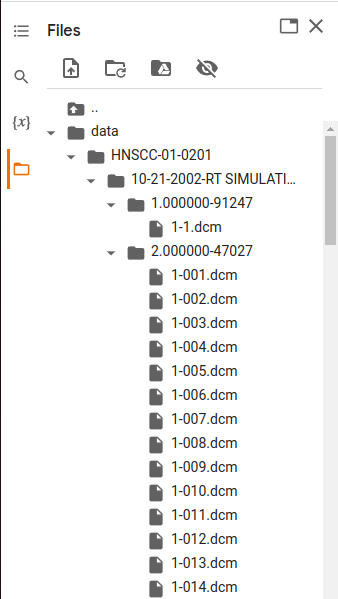

In [ ]:
sorted_image_paths = rai.sort_dicom_image_paths(paths=image_paths)

# Prune the images used just for this demo (makes final download size smaller)
selected_sorted_image_paths = sorted_image_paths[14:78]

# Use the following to instead use the entire image stack:
# selected_sorted_image_paths = sorted_image_paths

## Use `pydicom` to load the DICOM images

In [ ]:
sorted_image_series = [pydicom.dcmread(path) for path in selected_sorted_image_paths]

# Verify that these images weren't used within model training

In [ ]:
utilisation = dicom_utilisation(sorted_image_series[0])
utilisation

This image has been used within the "validation set". This means that even though this image set was kept out of the training loop itself, machine learning parameters may have been tweaked in order to improve the results on this image set. (They were).

Keep this in mind, it means that results on this particular image set are potentially going to be more favourable than a completely unseen imaging dataset.

In [ ]:
for ds in sorted_image_series:
    assert dicom_utilisation(ds) == utilisation

## Convert the DICOM files into an image stack for AI inference

In [ ]:
grids, image_stack = rai.sorted_image_series_to_image_stack_hfs(
    cfg=cfg, sorted_image_series=sorted_image_series)

## Load the RAi models

In [ ]:
models = rai.load_models(cfg=cfg)

## Run the inference

In [ ]:
predicted_masks = rai.inference(
    cfg=cfg,
    models=models,
    image_stack=image_stack,
    max_batch_size=10,
)

## Convert the AI model output into contour lines

In [ ]:
predicted_contours_by_structure = rai.masks_to_contours_by_structure(
    cfg=cfg,
    grids=grids, 
    masks=predicted_masks, 
    structure_names=cfg["structures"],
)

## View the results within this notebook

In [ ]:
vmin = 0.22
vmax = 0.35
figsize = (8, 8)

In [ ]:
slice_indices, axis_limits = rai.view_ranges_from_contours_by_structure(predicted_contours_by_structure, buffer=20)

rai.plot_contours_by_structure(
    grids=grids,
    images=image_stack,
    contours_by_structure=predicted_contours_by_structure,
    orientation="transverse",
    slice_indices=slice_indices,
    axis_limits=axis_limits,
    structure_names=cfg["structures"],
    figsize=figsize,
    vmin=vmin,
    vmax=vmax,
)

## Create a DICOM structure file from the results

In [ ]:
created_structure_ds = rai.create_dicom_structure_set(
    cfg=cfg, 
    image_series_headers=sorted_image_series, 
    contours_by_structure=predicted_contours_by_structure
)

In [ ]:
created_structure_path = pathlib.Path("RS-RAi.dcm")

pydicom.dcmwrite(filename=created_structure_path, dataset=created_structure_ds, write_like_original=False)

## Save the created structure file and the original DICOM images to a zip file

In [ ]:
save_to_images_directory = selected_sorted_image_paths + [data_license_path, data_readme_path]
save_to_structure_directory = [rai_license_path, created_structure_path]

with zipfile.ZipFile('results.zip', 'w', compression=zipfile.ZIP_DEFLATED) as results_zip:
    for path in save_to_images_directory:
        results_zip.write(path, f"HNSCC/{path.name}")
        
    for path in save_to_structure_directory:
        results_zip.write(path, f"RAi/{path.name}")

## Viewing the DICOM files

Once the cell below has run it will provide an interactive DICOM viewer. For instructions on how to use this viewer see the details within the section ["Instructions for viewing the DICOM files"](#Instructions-for-viewing-the-DICOM-files) at the bottom of this notebook.

In [ ]:
from IPython.display import IFrame
IFrame('https://dicom.radiotherapy.ai/local', width=1200, height=800)

## Instructions for viewing the DICOM files

We are now going to view these DICOM files. A DICOM viewer has been copied in above these instuctions within the section ["Viewing the DICOM files"](#Viewing-the-DICOM-files). To be able to view these DICOM files within that viewer the following steps are required:

* Download the `results.zip`
* Extract it to a local directory
* Within the DICOM viewer at the bottom of this notebook click *load folders*
* Scroll down to the **RTSTRUCT** series on the left-hand panel
* Double-click on the **RTSTRUCT** series
* Scroll the CT scan images to the middle slices for viewing

Screen shots of the above steps are given below.

### Download `results.zip`

Once the results zip file has been created, right click on `results.zip` within the Google Colab file browser and then click download:

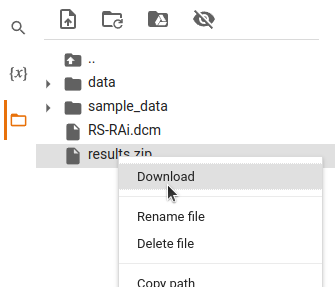

### Loading into the viewer

Once downloaded, extract them to a local directory. Then, within the viewer under the section ["Viewing the DICOM files"](#Viewing-the-DICOM-files), click load folders:

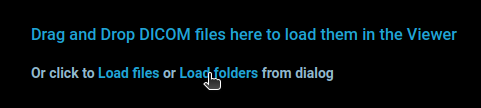

### RTSTRUCT

Scroll down to the bottom and double click on the RTSTRUCT series:

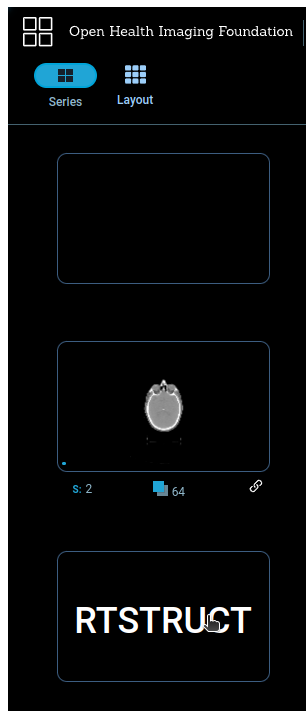

### Viewer control

Scroll the mouse wheel to go to approximately the middle slice to view the contours. Click the mouse wheel to pan. Right click and drag to zoom.

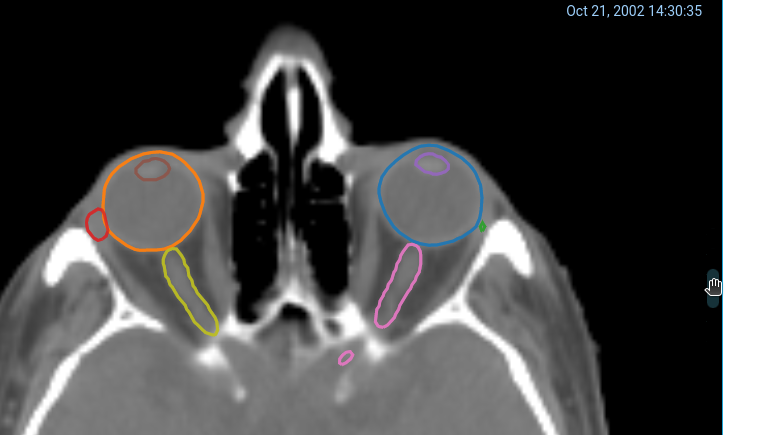